In [1]:
import pandas as pd
import numpy as np

from ExpAL.core import ExpAL,ExpALRetro
from ExpAL.methods import Query_by_Committee, Greedy, Random_Pick
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import matplotlib.pyplot as plt

# Retrospective AL

## Single Experiment

In [11]:
#Define the partion ratio of starting set and pool set in retrospective active learning
POOL_SIZE = 0.98

# Load Concrete strength dataset
concrete = pd.read_csv('data/Concrete_Data.csv')
y = np.array(concrete.pop('Concrete compressive strength(MPa, megapascals) '))
X = np.array(concrete)

#Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Split the starting set and pool set
X_start, X_pool, y_start, y_pool = train_test_split(
    X, y, test_size=POOL_SIZE, shuffle=True
)

In [12]:
#Define the parameters in active learning
EVAL_REGR = RandomForestRegressor()
BATCH_SIZE = 4

AL_ROUND = 20
CV_FOLD = 6

#Initialize the active learning instances
al_benchmark = {
    'Random':ExpALRetro(eval_regr=EVAL_REGR, batch_size=BATCH_SIZE),
    'Greedy':ExpALRetro(eval_regr=EVAL_REGR, batch_size=BATCH_SIZE),
    'QBC':ExpALRetro(eval_regr=EVAL_REGR, batch_size=BATCH_SIZE)
}

#Create method dict
al_method = {
    'Random':Random_Pick,
    'Greedy':Greedy,
    'QBC':Query_by_Committee
}

#Initialize preformance dict
al_performance = {
    'Random':np.zeros(AL_ROUND),
    'Greedy':np.zeros(AL_ROUND),
    'QBC':np.zeros(AL_ROUND)
}


for method in al_benchmark.keys():
    #Add initial data to the active learning instance
    al_benchmark[method].init(X_start,y_start,X_pool,y_pool)

    for i in range(AL_ROUND):
        #Obtaining the value and indices of the recommended instances
        X_query, query_indices = al_benchmark[method].query(al_method[method])
        
        #Add the results back to the starting set
        al_benchmark[method].add_results(al_benchmark[method].X_pool[query_indices],al_benchmark[method].y_pool[query_indices])

        #Remove the queried entries from pool set
        al_benchmark[method].remove_from_pool(query_indices)

        #Record results
        al_performance[method][i] = -al_benchmark[method].eval(cv=CV_FOLD).mean()

model_performance_DF = pd.DataFrame.from_dict(al_performance)
model_performance_DF['AL_round'] = list(range(AL_ROUND))

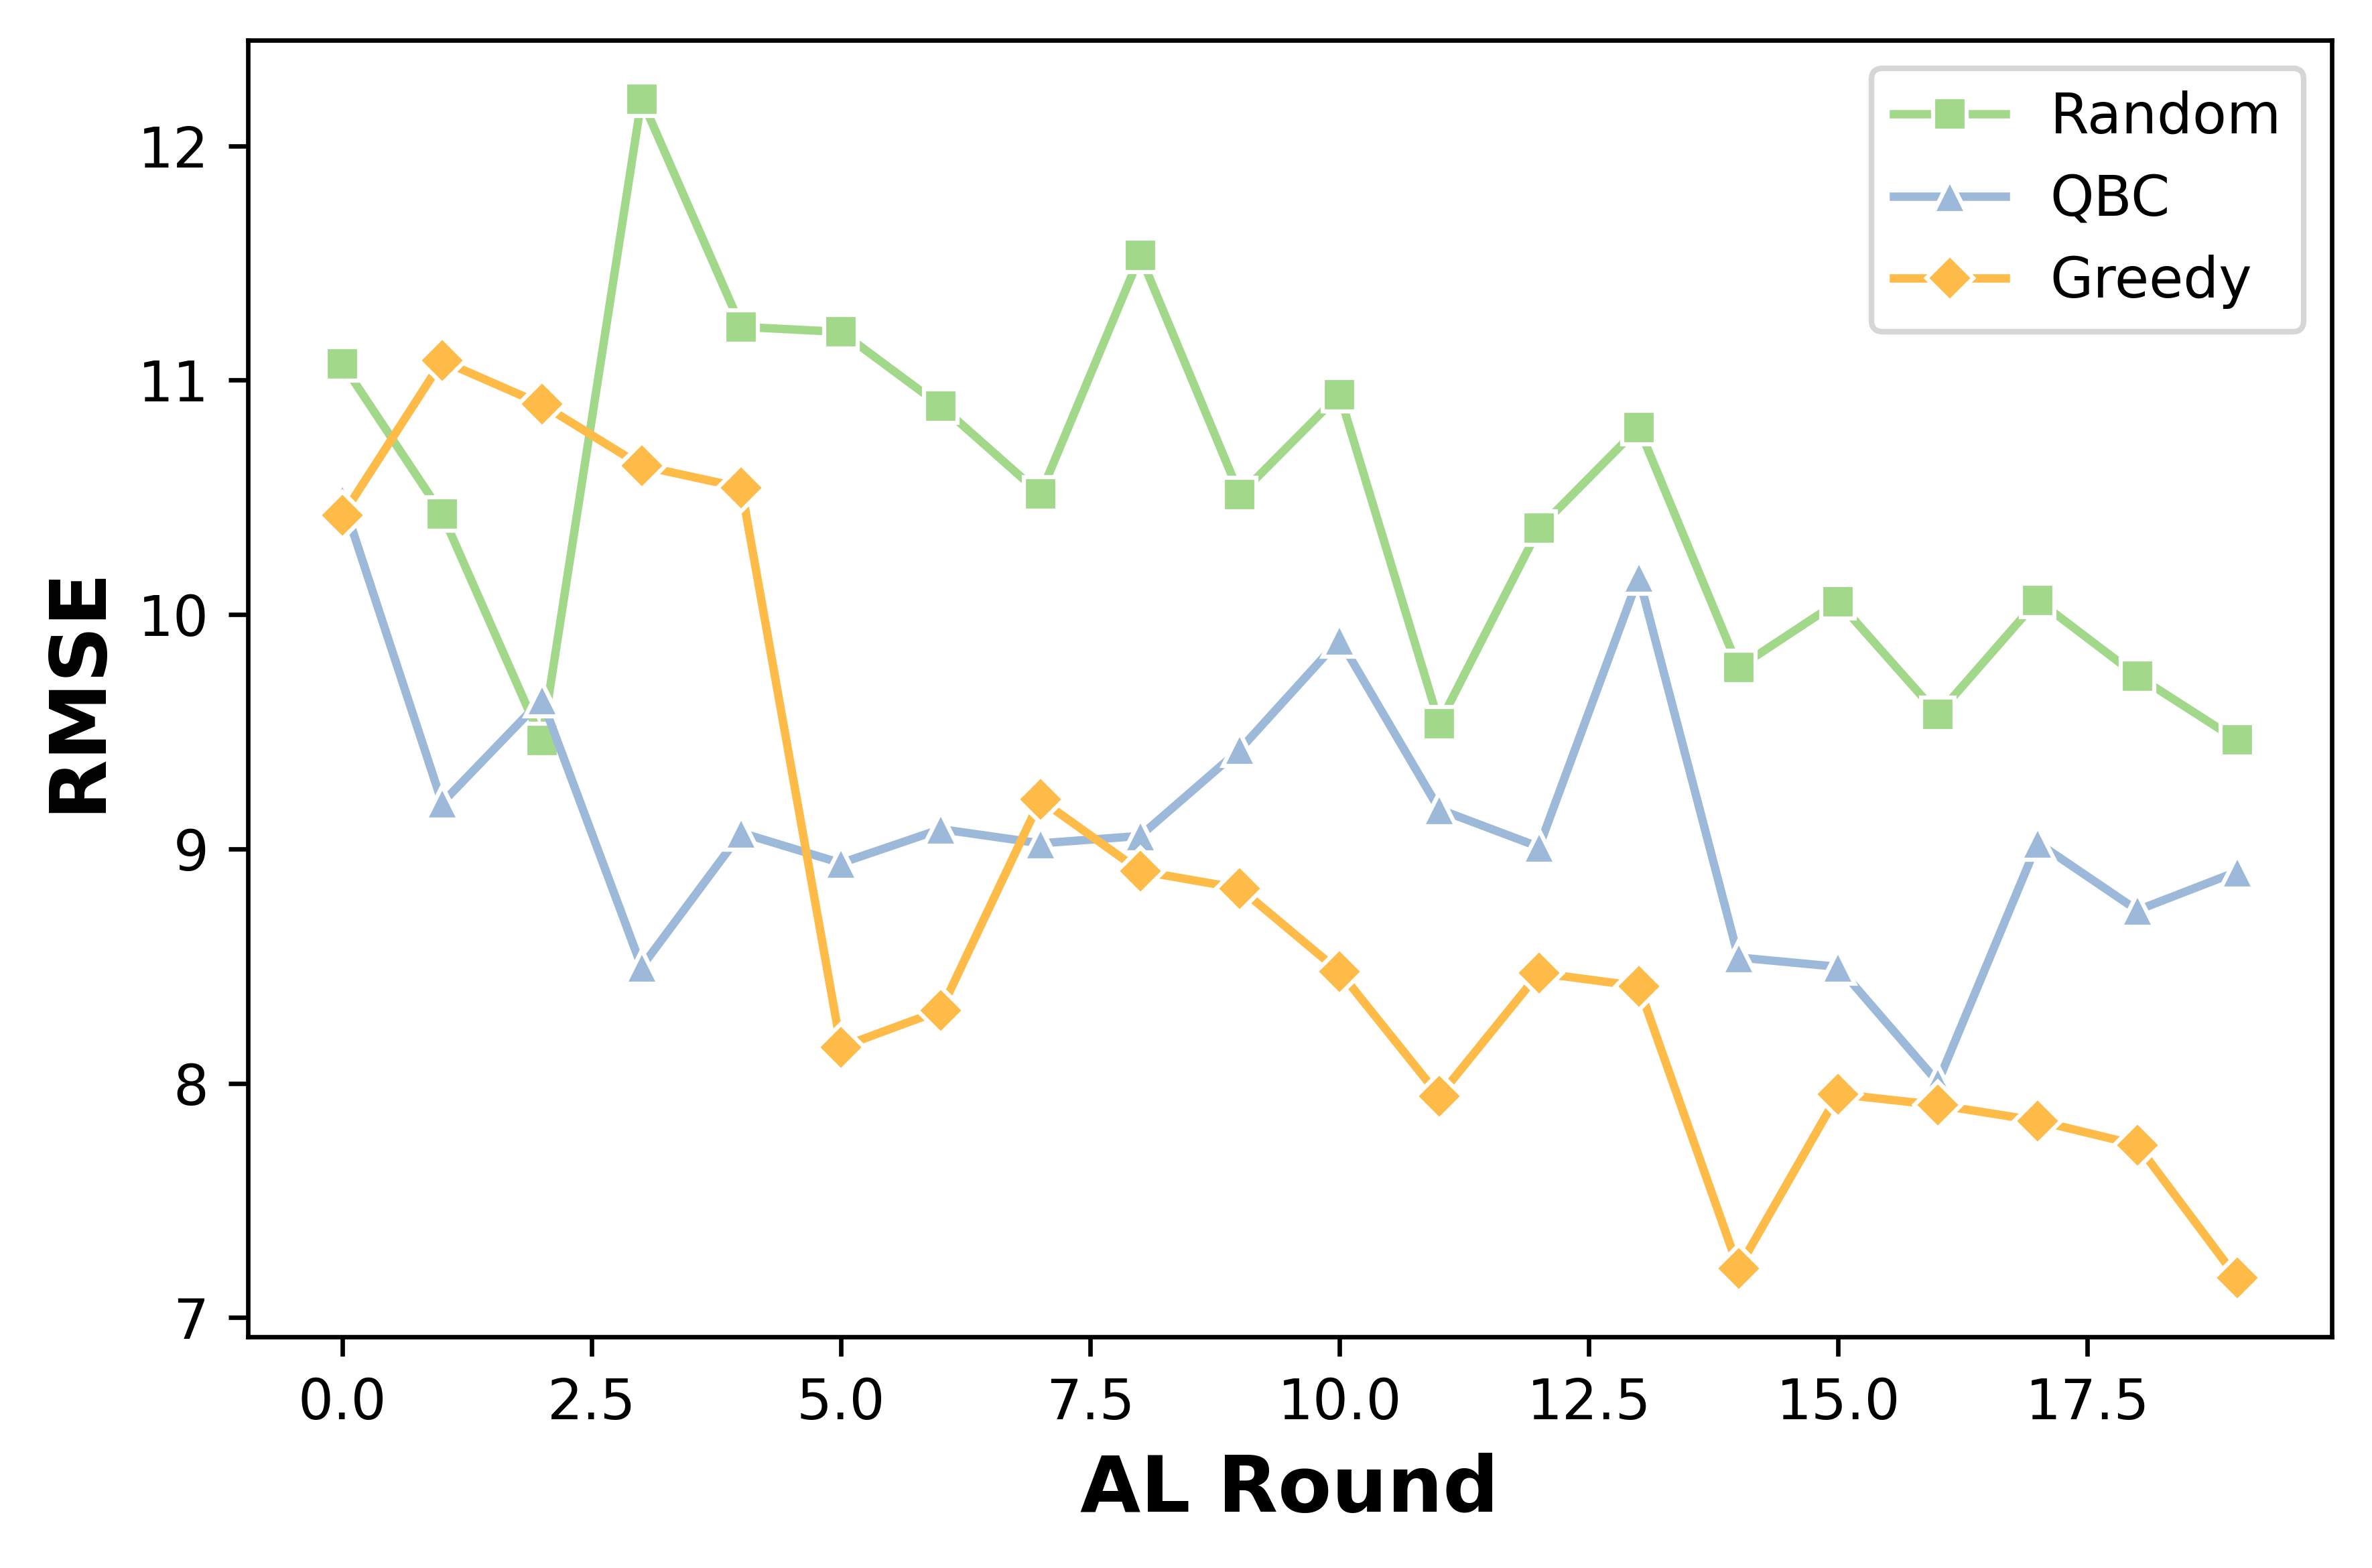

In [28]:
plt.figure(figsize=(6, 4), dpi=600)

Color_Random = sns.color_palette("YlGn", 4)[1]
Color_QBC = sns.color_palette("PuBu", 4)[1]
Color_Greedy = sns.color_palette("YlOrBr", 4)[1]

ax = sns.lineplot(x="AL_round", y="Random",
    marker="s", data=model_performance_DF,
    color=Color_Random, label='Random'
)

ax = sns.lineplot(x="AL_round", y="QBC",
    marker="^", data=model_performance_DF,
    color=Color_QBC, label='QBC'
)

ax = sns.lineplot(x="AL_round", y="Greedy",
    marker="D", data=model_performance_DF,
    color=Color_Greedy, label='Greedy'
)

plt.ylabel("RMSE", weight="bold", fontsize=14)
plt.xlabel("AL Round", weight="bold", fontsize=14)
plt.tight_layout()
plt.show()

## Repeated Experiments (to obtain error bars)

In [14]:
#Define the partion ratio of starting set and pool set in retrospective active learning
POOL_SIZE = 0.98

# Load Concrete strength dataset
concrete = pd.read_csv('data/Concrete_Data.csv')
y = np.array(concrete.pop('Concrete compressive strength(MPa, megapascals) '))
X = np.array(concrete)

#Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [25]:
Num_repeat = 100

#Define the parameters in active learning
EVAL_REGR = RandomForestRegressor()
BATCH_SIZE = 4

AL_ROUND = 20
CV_FOLD = 6

#Initialize the result dataframe
Benchmark_Res = pd.DataFrame(columns=['Random','Greedy','QBC','AL_round','Repeat'])

for t in range(Num_repeat):
    #Start with random partitioned starting and pool set each time
    X_start, X_pool, y_start, y_pool = train_test_split(
        X, y, test_size=POOL_SIZE, shuffle=True, random_state = t
    )

    #Initialize the active learning instances
    al_benchmark = {
        'Random':ExpALRetro(eval_regr=EVAL_REGR, batch_size=BATCH_SIZE),
        'Greedy':ExpALRetro(eval_regr=EVAL_REGR, batch_size=BATCH_SIZE),
        'QBC':ExpALRetro(eval_regr=EVAL_REGR, batch_size=BATCH_SIZE)
    }

    #Create method dict
    al_method = {
        'Random':Random_Pick,
        'Greedy':Greedy,
        'QBC':Query_by_Committee
    }

    #Initialize preformance dict
    al_performance = {
        'Random':np.zeros(AL_ROUND),
        'Greedy':np.zeros(AL_ROUND),
        'QBC':np.zeros(AL_ROUND)
    }


    for method in al_benchmark.keys():
        #Add initial data to the active learning instance
        al_benchmark[method].init(X_start,y_start,X_pool,y_pool)

        for i in range(AL_ROUND):
            #Obtaining the value and indices of the recommended instances
            X_query, query_indices = al_benchmark[method].query(al_method[method])
            
            #Add the results back to the starting set
            al_benchmark[method].add_results(al_benchmark[method].X_pool[query_indices],al_benchmark[method].y_pool[query_indices])

            #Remove the queried entries from pool set
            al_benchmark[method].remove_from_pool(query_indices)

            #Record results
            al_performance[method][i] = -al_benchmark[method].eval(cv=CV_FOLD, n_jobs=-1).mean()
    
    #Create result dataframe
    model_performance_DF = pd.DataFrame.from_dict(al_performance)
    model_performance_DF['AL_round'] = list(range(AL_ROUND))
    model_performance_DF['Repeat'] = t

    #Appending results to the grand result dataframe
    Benchmark_Res = pd.concat([Benchmark_Res,model_performance_DF],ignore_index=True)

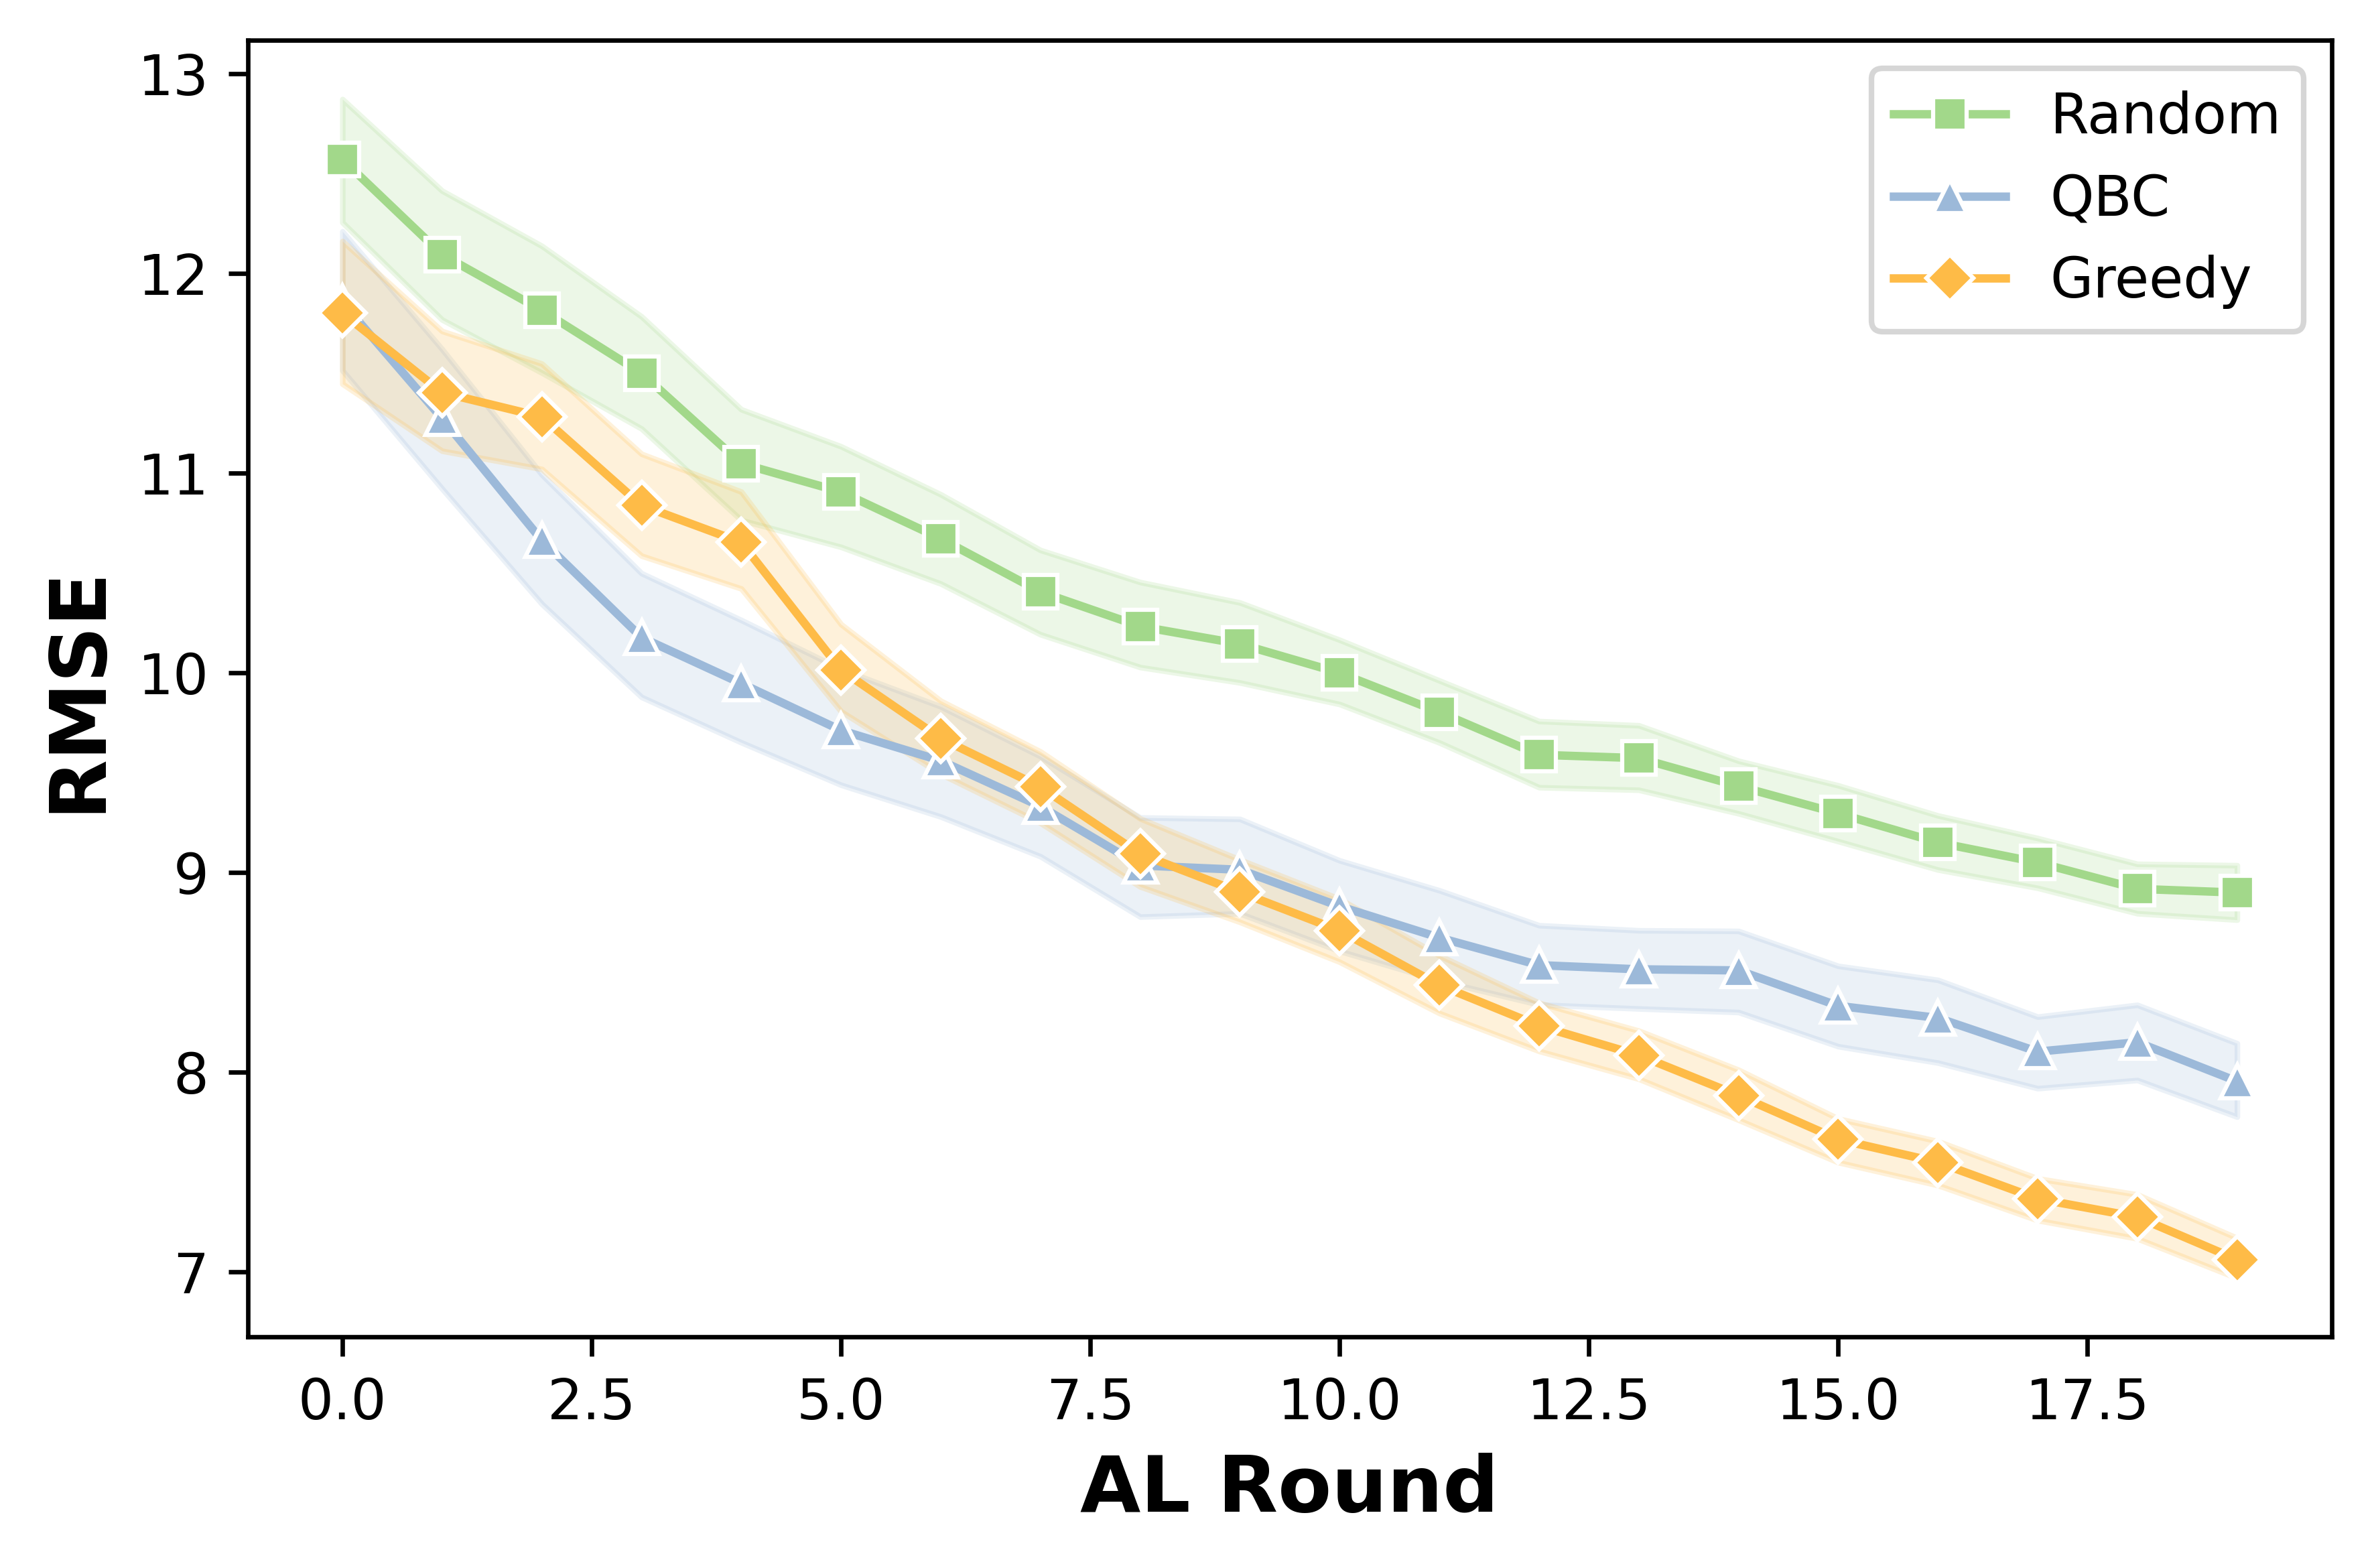

In [26]:
plt.figure(figsize=(6, 4), dpi=600)

Color_Random = sns.color_palette("YlGn", 4)[1]
Color_QBC = sns.color_palette("PuBu", 4)[1]
Color_Greedy = sns.color_palette("YlOrBr", 4)[1]

ax = sns.lineplot(x="AL_round", y="Random",
    marker="s", data=Benchmark_Res,
    color=Color_Random, label='Random'
)

ax = sns.lineplot(x="AL_round", y="QBC",
    marker="^", data=Benchmark_Res,
    color=Color_QBC, label='QBC'
)

ax = sns.lineplot(x="AL_round", y="Greedy",
    marker="D", data=Benchmark_Res,
    color=Color_Greedy, label='Greedy'
)

plt.ylabel("RMSE", weight="bold", fontsize=14)
plt.xlabel("AL Round", weight="bold", fontsize=14)
plt.tight_layout()
plt.show()

# Prospective AL (Concrete strength dataset as an example)

In [17]:
# Load all existing data, using Concrete strength dataset as an example
concrete = pd.read_csv('data/Concrete_Data.csv')
y = np.array(concrete.pop('Concrete compressive strength(MPa, megapascals) '))
X = np.array(concrete)


#Defining potential experiment matrix X_pool with a full factorial design
pool_raw = []
for c1 in np.linspace(100,600,num=5):
    for c2 in np.linspace(0,400,num=4):
        for c3 in np.linspace(0,300,num=4):
            for c4 in np.linspace(0,40,num=4):
                for c5 in np.linspace(800,1000,num=2):
                    for c6 in np.linspace(600,700,num=4):
                        for c7 in np.linspace(1,7,num=4):
                            for c8 in np.linspace(1,7,num=4):
                                new_experiment = [c1,c2,c3,c4,c5,c6,c7,c8]
                                pool_raw.append(new_experiment)

#Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_pool = scaler.transform(pool_raw)

#Check defined experiments
pool_DF = pd.DataFrame(pool_raw,columns = concrete.columns)
pool_DF

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,100.0,0.0,0.0,0.0,800.0,600.0,1.0,1.0
1,100.0,0.0,0.0,0.0,800.0,600.0,1.0,3.0
2,100.0,0.0,0.0,0.0,800.0,600.0,1.0,5.0
3,100.0,0.0,0.0,0.0,800.0,600.0,1.0,7.0
4,100.0,0.0,0.0,0.0,800.0,600.0,3.0,1.0
...,...,...,...,...,...,...,...,...
40955,600.0,400.0,300.0,40.0,1000.0,700.0,5.0,7.0
40956,600.0,400.0,300.0,40.0,1000.0,700.0,7.0,1.0
40957,600.0,400.0,300.0,40.0,1000.0,700.0,7.0,3.0
40958,600.0,400.0,300.0,40.0,1000.0,700.0,7.0,5.0


In [18]:
#Define the parameters in active learning
EVAL_REGR = RandomForestRegressor()
BATCH_SIZE = 4
QUERY_METHOD = Greedy

#Initialize the active learning instance
al = ExpAL(eval_regr=EVAL_REGR, batch_size=BATCH_SIZE)

#Add initial data to the active learning instance
al.init(X,y,X_pool)

#Check for initial model performance
print('Initial Model Performance (RMSE): {:.2f}'.format(-al.eval().mean()))

Initial Model Performance (RMSE): 4.96


## 1st Round AL

In [19]:
#Obtaining the value and indices of the recommended instances
X_query, query_indices = al.query(QUERY_METHOD)

#Inverse the transformation in preprocessing to show raw feature
X_query_raw = scaler.inverse_transform(X_query)
X_query_DF = pd.DataFrame(X_query_raw,columns=concrete.columns)

#Revealing the recommended experiments
X_query_DF

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,600.0,400.0,300.0,0.0,1000.0,600.0,1.0,1.0
1,600.0,400.0,300.0,0.0,1000.0,600.0,1.0,3.0
2,600.0,400.0,300.0,0.0,1000.0,600.0,1.0,5.0
3,600.0,400.0,300.0,0.0,1000.0,600.0,1.0,7.0


In [20]:
### Shift to lab experiments to obtain experiment results! ###
y_round1 = []

#In this demonstration, we randomly assign some value to pretend we did some experiments
y_round1 = [30,40,50,60]

In [21]:
#Add the results back to the starting set
al.add_results(al.X_pool[query_indices],y_round1)

#Remove the queried entries from pool set
al.remove_from_pool(query_indices)

#Check for model performance
print('Round {} Model Performance (RMSE): {:.2f}'.format(al.ALround,-al.eval().mean()))

Round 1 Model Performance (RMSE): 4.93


## 2nd Round AL

In [22]:
#Obtaining the value and indices of the recommended instances
X_query, query_indices = al.query(QUERY_METHOD)

#Inverse the transformation in preprocessing to show raw feature
X_query_raw = scaler.inverse_transform(X_query)
X_query_DF = pd.DataFrame(X_query_raw,columns=concrete.columns)

#Revealing the recommended experiments
X_query_DF

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,600.0,400.0,300.0,0.0,1000.0,600.0,3.0,1.0
1,600.0,400.0,300.0,0.0,1000.0,600.0,3.0,3.0
2,600.0,400.0,300.0,0.0,1000.0,600.0,3.0,5.0
3,600.0,400.0,300.0,0.0,1000.0,600.0,3.0,7.0


In [23]:
### Shift to lab experiments to obtain experiment results! ###
y_round2 = []

#In this demonstration, we randomly assign some value to pretend we did some experiments
y_round2 = [35,45,55,65]

In [24]:
#Add the results back to the starting set
al.add_results(al.X_pool[query_indices],y_round2)

#Remove the queried entries from pool set
al.remove_from_pool(query_indices)

#Check for model performance
print('Round {} Model Performance (RMSE): {:.2f}'.format(al.ALround,-al.eval().mean()))

Round 2 Model Performance (RMSE): 5.07
